## RNN for fake news detection

### Setup

In [1]:
# string manipulation
import re

# common imports
import pandas as pd
import numpy as np

# deep learning libraries
import tensorflow as tf
from tensorflow import keras

# setting random seed
np.random.seed(42)
tf.random.set_seed(42)

# Style setup
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=16)
mpl.rc('ytick', labelsize=12)
plt.style.use('fivethirtyeight')
plt.xkcd(False) 

### Loading data

You can find the dataset on kaggle: fake news competition

In [2]:
dataset = pd.read_csv(r'C:\Users\Aless\Downloads\fake_news\train.csv', index_col = 'id')
dataset.head()

,title,author,text,label
id,,,,
0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


### Data validation

In [3]:
print('dataset shape: ', dataset.shape)
print('dataset columns: ', dataset.columns)
print('Percentage of fake news: {}%'.format(np.round(dataset.label.value_counts(normalize = True).loc[1], 4) * 100))

dataset shape:  (20800, 4)
dataset columns:  Index(['title', 'author', 'text', 'label'], dtype='object')
Percentage of fake news: 50.06%


#### Missing values

In [4]:
dataset.isna().sum()

title      558
author    1957
text        39
label        0
dtype: int64

Let us have a look to the distribution of the label within the mssing values

Text(0.5, 1.0, 'Distribution of news label without title')

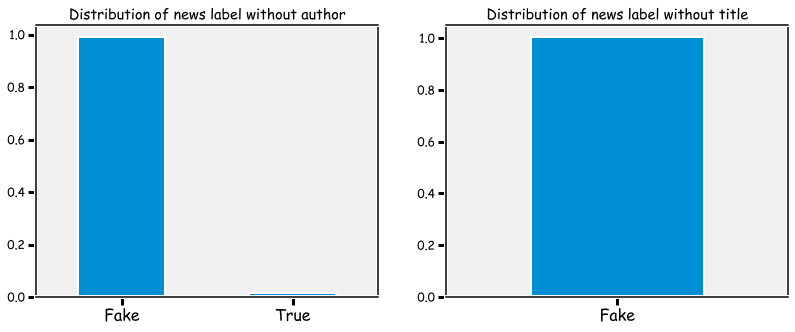

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12,5))
ticklabel = ['Fake', 'True']


dataset.loc[dataset['author'].isna(), :]['label'].value_counts(normalize = True).plot(kind = 'bar', ax = ax1)
ax1.set_xticklabels(ticklabel, rotation = 0.5); ax1.set_title('Distribution of news label without author')

dataset.loc[dataset['title'].isna(), :]['label'].value_counts(normalize = True).plot(kind = 'bar', ax = ax2)
ax2.set_xticklabels(ticklabel, rotation = 0.5); ax2.set_title('Distribution of news label without title')

As we can see news without an author are very likely to be fake within the dataset. This consideration can be extended with a good confidence also to the real problem: fake news' writers generally prefer to remain anonymous, in order to avoid any possible penal implications. For this reason we are not going to drop missing values related to author, but rather assign to the an 'unknown' value, in order to be analyze as a factor by the model.

For what concern 'title' the decision is a bit more tricky. Titles are one of the strength of fake news world, and are the more responsible for generating engagement, so it is very unlikely that a fake news is not published with a catchy title. In this way, when our model will be launched in production, it will be almost useless recognize pattern in news without title, since it will be very hard to find some. At the end the ultimate decision is to drop 'nan' title, in order to make train and convergence a little bit faster.

In [6]:
dataset['author'].replace(np.nan, 'unknown', inplace = True)
dataset.dropna(inplace = True)
print('New shape: ', dataset.shape)

New shape:  (20203, 4)


In [7]:
dataset['author'].value_counts()[:20]

unknown                1918
Pam Key                 243
admin                   193
Jerome Hudson           166
Charlie Spiering        141
John Hayward            140
Katherine Rodriguez     124
Warner Todd Huston      122
Ian Hanchett            119
Breitbart News          118
Daniel Nussbaum         112
AWR Hawkins             107
Jeff Poor               107
Joel B. Pollak          106
Trent Baker             102
Breitbart London         97
Bob Price                93
Ben Kew                  90
Charlie Nash             88
Pakalert                 86
Name: author, dtype: int64

### Visualizing most common words

I am going to create a word cloud for fake and actual news in order to extract general information

Text(0.5, 1.0, 'Word cloud for fake news')

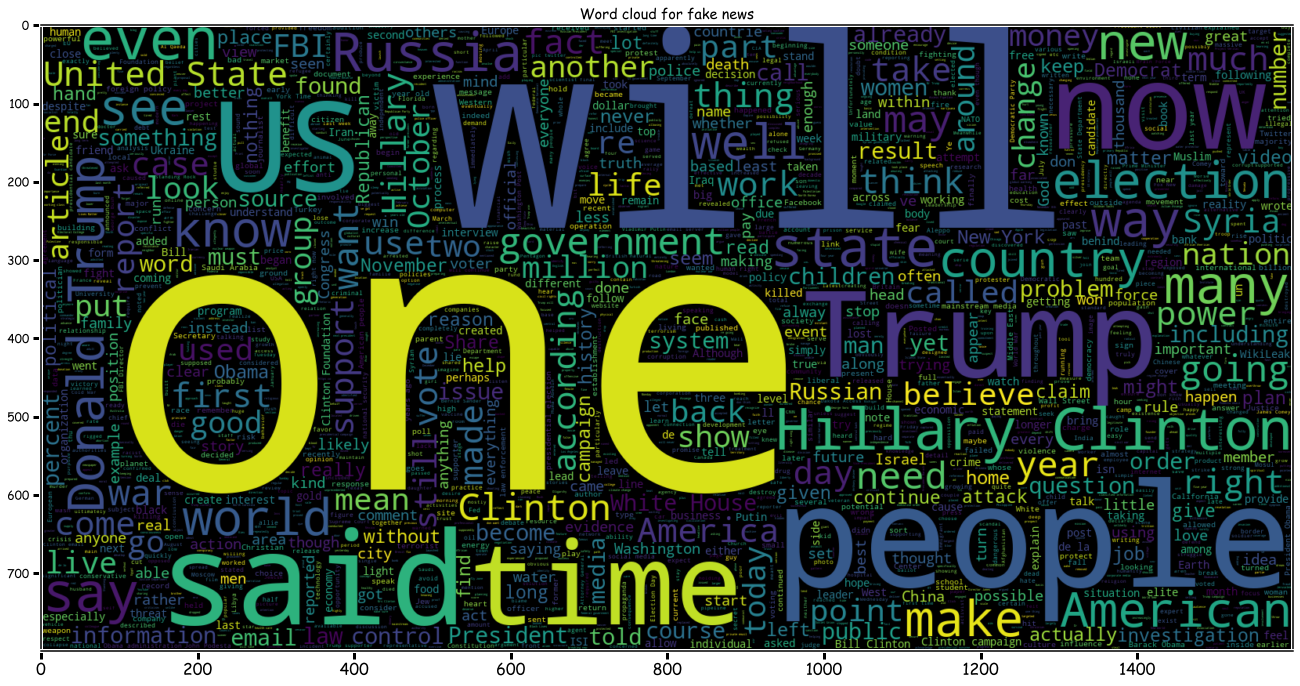

In [8]:
from wordcloud import WordCloud, STOPWORDS

plt.figure(figsize = (20, 20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(dataset.loc[dataset.label == 1].text))
plt.imshow(wc , interpolation = 'bilinear')
plt.title('Word cloud for fake news')

Text(0.5, 1.0, 'Word cloud for real news')

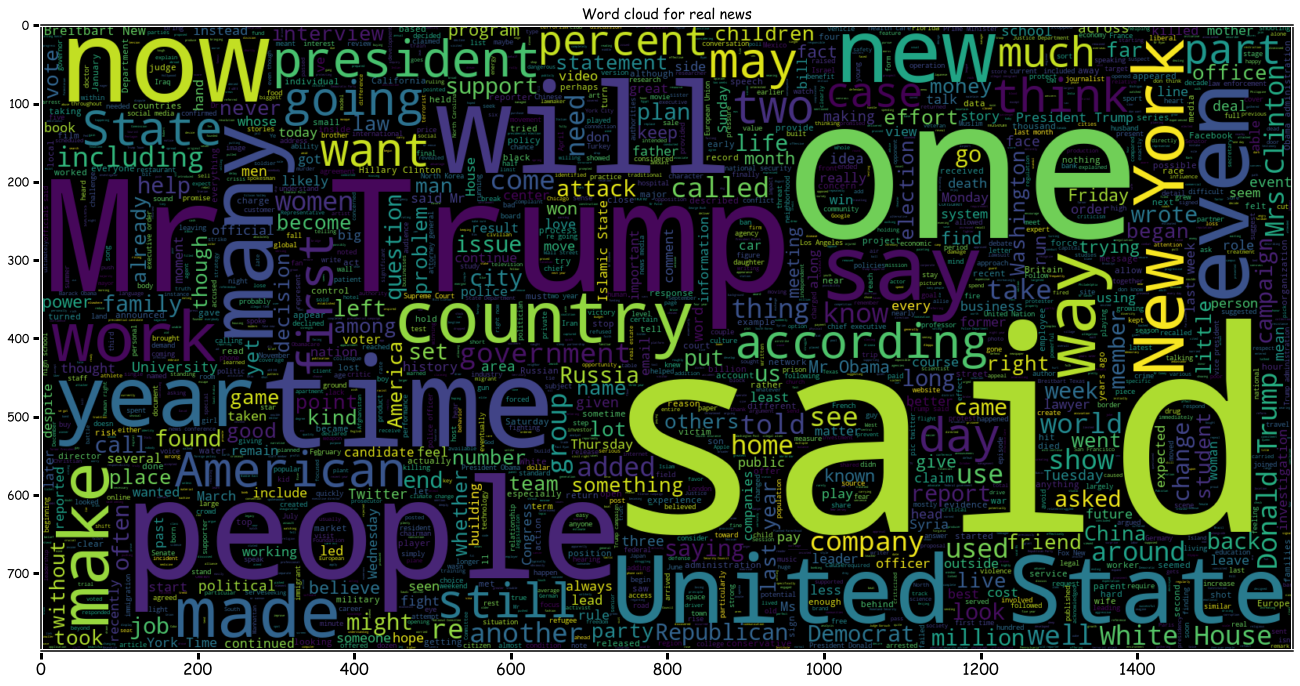

In [9]:
plt.figure(figsize = (20, 20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(dataset.loc[dataset.label == 0].text))
plt.imshow(wc , interpolation = 'bilinear')
plt.title('Word cloud for real news')

A peculiar insight we can take from these visualiztions is about Hilary Clinton: it turns out that is very common to find her in fake news article but in true ones her name does not appear in the most used words

### Set creation

Often simple analysis lead to good results so i decided to analyze the title and the text of an article as a whole. After this i am going to create a training and a validation set for my neural network

In [10]:
dataset['corpus'] = dataset['title'] + ' ' + dataset['text']
dataset.drop(['text', 'title'], axis = 1, inplace = True)

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

X, y = dataset.drop('label', axis = 1), dataset['label']
X, y = shuffle(X, y, random_state = 42)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train_text = X_train['corpus']
X_valid_text = X_valid['corpus']

### Text preprocessing

Now that i have my sets i can preprocess them: i am going to remove url, additional spaces and special characters from the corpus

In [11]:
def preprocess(data):
    text_preprocessed = []
    for text in data:
        text = text.lower()
        text = re.sub('https?://\S+|www\.\S+', '', text)
        text = re.sub('\\W', ' ', text)
        text = re.sub(' +', ' ', text)
        text = re.sub(' $', '', text)
        text = re.sub('^ ', '', text)
        text = re.sub('\n', '', text)
        text_preprocessed.append(text)
    return np.array(text_preprocessed)

X_train_text = preprocess(X_train_text)
X_valid_text = preprocess(X_valid_text)

Last step is to fit a tokenizer on the text and to pad the generated sequences, so we will be sure that every inputs of the neural network will have the same length 

In [12]:
from keras.preprocessing.text import Tokenizer

max_vocab = 10000
tokenizer = Tokenizer(num_words = max_vocab)
tokenizer.fit_on_texts(X_train_text)

X_train_text = tokenizer.texts_to_sequences(X_train_text)
X_valid_text = tokenizer.texts_to_sequences(X_valid_text)
X_train_text = keras.preprocessing.sequence.pad_sequences(X_train_text, padding = 'post', maxlen = 256)
X_valid_text = keras.preprocessing.sequence.pad_sequences(X_valid_text, padding = 'post', maxlen = 256)

Using TensorFlow backend.


### Building the model

For the actual model i decided to use Gatered Recurrent Units (GRU) and to apply a bidirectional layers on them in order to analyze past and following parts of text. This part is built at the top of an embedding layer which has the task to map words into vectors

In [13]:
embed_size = 32

model = keras.Sequential([keras.layers.Embedding(max_vocab, embed_size),
                          keras.layers.Bidirectional(keras.layers.GRU(64, return_sequences=True)),
                          keras.layers.Bidirectional(keras.layers.GRU(32)),
                          keras.layers.Dense(128, activation='relu'),
                          keras.layers.Dropout(0.5),
                          keras.layers.Dense(1)])

### Training on data

The last step is to compile and train the model

In [14]:
stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)
model.compile(loss = 'binary_crossentropy', optimizer= keras.optimizers.Adam(1e-4), metrics = ['accuracy'])
history = model.fit(X_train_text, y_train, epochs = 10, batch_size = 64, shuffle = True,
                    validation_data = (X_valid_text, y_valid),
                    callbacks = [stop])

Epoch 1/10
253/253 [==============================] - 69s 272ms/step - loss: 1.3259 - accuracy: 0.5131 - val_loss: 0.7789 - val_accuracy: 0.5184
Epoch 2/10
253/253 [==============================] - 66s 260ms/step - loss: 0.6930 - accuracy: 0.5677 - val_loss: 0.6416 - val_accuracy: 0.6476
Epoch 3/10
253/253 [==============================] - 66s 262ms/step - loss: 0.6400 - accuracy: 0.6277 - val_loss: 0.6004 - val_accuracy: 0.6815
Epoch 4/10
253/253 [==============================] - 67s 263ms/step - loss: 0.5724 - accuracy: 0.6983 - val_loss: 0.5368 - val_accuracy: 0.7619
Epoch 5/10
253/253 [==============================] - 66s 262ms/step - loss: 0.4808 - accuracy: 0.7815 - val_loss: 0.4163 - val_accuracy: 0.8134
Epoch 6/10
253/253 [==============================] - 67s 264ms/step - loss: 0.3436 - accuracy: 0.8631 - val_loss: 0.3468 - val_accuracy: 0.8659
Epoch 7/10
253/253 [==============================] - 67s 266ms/step - loss: 0.2572 - accuracy: 0.9068 - val_loss: 0.3551 - val_ac

The model seems to achieve good perfomance, let us evaluate it on the test set. Note that the loss decreased every single epoch, so probably if we increase their number i will achieve better perfomances

### Deploying model in production

In [15]:
# uploading data
df_test = pd.read_csv(r'C:\Users\Aless\Downloads\fake_news\train.csv', index_col = 'id')
df_test['corpus'] = df_test['title'] + df_test['text']
df_test.dropna(inplace = True)
# creating data and label
X_test_text = df_test['corpus'].values
y_test = df_test['label'].values
# preprocessing
X_test_text = preprocess(X_test_text)
# tokenizing
X_test_text = tokenizer.texts_to_sequences(X_test_text)
X_test_text = keras.preprocessing.sequence.pad_sequences(X_test_text, padding = 'post', maxlen = 256)
# computing model perfomance
print('Model accuracy: {}'.format(np.round(model.evaluate(X_test_text, y_test)[1], 4) * 100))

572/572 [==============================] - 27s 46ms/step - loss: 0.2782 - accuracy: 0.9554
Model accuracy: 95.54


An accuracy above 95% is impressive, expecially if we consider that we loose a lot of information during preprocessing such as number of word per text, title number of upper case letter and more. Note that in the preprocessing phase and also in the 'model building' one there are a lot of hyperparameters that can be tuned (i.e. max_vocab, embed_size, n_neurons, n_layers, learning_rate and so on). This will for sure increase the overall perfomance of the model, even though the tuning process could be extremely computational expensive.